<a href="https://colab.research.google.com/github/PhamDucThinh1995/metal-nut-classification-segmentation/blob/main/metal_nut_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm
!pip install wandb
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import the necessary packages
import torch
import os
import cv2
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import pandas as pd
import multiprocessing as mp
import timm
import torchvision.transforms.functional as VisionF
import skimage.io as io
import seaborn as sns
import wandb
import typing 
import albumentations as A

from imutils import paths
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d, MaxPool2d
from torch.nn import Module, ModuleList
from torch.nn import ReLU, BatchNorm2d
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import CenterCrop, RandomRotation, RandomVerticalFlip
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from fastai.vision import *
from fastai.callback import *
from PIL import Image
from glob import glob
from fastprogress.fastprogress import master_bar, progress_bar
from torch.autograd import Variable
from tqdm import tqdm


In [3]:
wandb.init(project="my-test-project")

wandb: Currently logged in as: pdthinh1995. Use `wandb login --relogin` to force relogin


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# define the path to the images and masks dataset
DATASET_PATH = "/content/drive/MyDrive/metal_nut"
IMAGE_DATASET_PATH = os.path.join("/content/drive/MyDrive/metal_nut/train/good")
IMAGE_TEST_PATH = os.path.join("/content/drive/MyDrive/metal_nut/test")
MASK_DATASET_PATH = os.path.join("/content/drive/MyDrive/metal_nut/ground_truth")

PRE-PROCESSING DATA

In [6]:
def find_files(directory, file_format):
    """ 
    input = directory (path)
    input = file_format './*.png'
    outpur = list of files
    """
    files=glob(os.path.join(directory,file_format))
    return files

img_files=find_files(IMAGE_DATASET_PATH,'*.png') 

In [7]:
dirs = os.listdir(IMAGE_TEST_PATH)

vid_dirs= glob(os.path.join(IMAGE_TEST_PATH,'*'))
for i in range(len(vid_dirs)):
    vid_dirs[i] = vid_dirs[i].replace('\\', '/')

gtruth = glob(os.path.join(MASK_DATASET_PATH,'*'))
for i in range(len(gtruth)):
    gtruth[i] = gtruth[i].replace('\\', '/')

In [8]:
### Purpose: Split into "good" and "damaged" dataset for classification
metal_good=[]
metal_damaged=[]
mask_truth=[]
for i in range(len(vid_dirs)):
  if (vid_dirs[i].split('/')[-1])!='good':
    metal_damaged+=find_files(vid_dirs[i],'*.png')
  else:
    metal_good+=(find_files(IMAGE_DATASET_PATH,'*.png'))
for i in range(len(gtruth)):
  mask_truth+=find_files(gtruth[i],'*.png')

In [9]:
df_good = pd.DataFrame([])
df_good['imgs'] = metal_good
df_good['estimate'] = 'good'
df_good['tag'] = 1
df_damaged = pd.DataFrame([])
df_damaged['imgs'] = metal_damaged
df_damaged['estimate'] = 'dammaged'
df_damaged['tag'] = 0
df_=pd.concat([df_good,df_damaged],axis=0)

In [10]:
metal_damaged.sort()
mask_truth.sort()

In [11]:
df_segmentation = pd.DataFrame([])
df_segmentation['imgs'] = metal_damaged
df_segmentation['mask'] = mask_truth
df_segmentation['estimate'] = 'dammaged'
df_segmentation['tag'] = 0
df_segmentation.to_csv('./segmentation.csv',header=True,index=False)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(list(df_['imgs']), list(df_['tag']), test_size = 0.1, random_state=42,shuffle=True)

In [13]:
df_train = pd.DataFrame([])
df_train['imgs'] = X_train
df_train['target'] = y_train
df_train['is_valid'] = False
df_val = pd.DataFrame([])
df_val['imgs'] = X_val
df_val['target'] = y_val
df_val['is_valid'] = True
df_anno = pd.concat([df_train,df_val],axis=0)
df_anno.to_csv('./annotation.csv',header=True,index=False)

CLASSIFICATION IN GOOD OR DAMAGED

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [15]:
config = {}

config['size'] = 224
config['rotation_degrees']=90
config['angle_shear']=45
config['num_classes'] = 2
config['batch_size'] = 32
config['num_workers'] = 0
config['output_nodes'] = 2
config['epochs'] = 100
config['lr'] = 1e-3
# Optimizer parameters                                                                 
config['lr_step_size'] = 10              
config['lr_gamma'] = 0.8   
config['momentum'] = 0.9                             
config['weight_decay'] = 0.05           

In [16]:
df_data = pd.read_csv('./annotation.csv')
df_data.head()

,imgs,target,is_valid
0,/content/drive/MyDrive/metal_nut/train/good/04...,1,False
1,/content/drive/MyDrive/metal_nut/train/good/10...,1,False
2,/content/drive/MyDrive/metal_nut/train/good/01...,1,False
3,/content/drive/MyDrive/metal_nut/train/good/08...,1,False
4,/content/drive/MyDrive/metal_nut/test/scratch/...,0,False


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


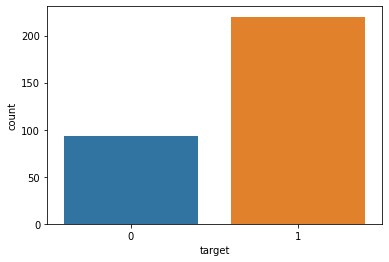

In [17]:
g = sns.countplot(df_data['target'])

In [18]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [19]:
mean = [0.485, 0.456, 0.406]                                               
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((config['size'],config['size'])),
    transforms.RandomRotation(degrees=config['rotation_degrees']),
    transforms.RandomAffine(degrees=(30, 60),shear=config['angle_shear']),
    transforms.ToTensor(),
    GaussianNoise(0.05, 0.2),
    transforms.Normalize(mean, std)])

valid_transform = transforms.Compose([
    transforms.Resize((config['size'],config['size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

class METALNUTDataset(Dataset):                                                   
    
    def __init__(self, df, transform):
        """
        df: is the dataframe annotation image and attribute
        transform: transform augmentation
        """
        self.df = df
        self.transform = transform
        self.image = list(self.df['imgs'])        
        self.target = list(self.df['target'])

    def __getitem__(self, idx):
        
        img_path = self.image[idx]
        img_arr = cv2.imread(img_path)
        img = Image.fromarray(img_arr)
        img = self.transform(img)

        target = torch.tensor(int(self.target[idx]))
        target = target.type(torch.LongTensor)

        return img, target
    
    def __len__(self):
        return len(self.df)

In [20]:
train_ds = METALNUTDataset(df=df_data[df_data['is_valid']==False] , transform = train_transform)
valid_ds = METALNUTDataset(df=df_data[df_data['is_valid']==True] , transform = valid_transform)
train_dl = DataLoader(train_ds, config['batch_size'], config['num_workers'])    
valid_dl = DataLoader(valid_ds, config['batch_size'], config['num_workers'])

In [21]:
def show_batch(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig=plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
def show(imgs):
  if not isinstance(imgs, list):
      imgs = [imgs]
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
      img = img.detach()
      img = VisionF.to_pil_image(img)
      axs[0, i].imshow(np.asarray(img))
      axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

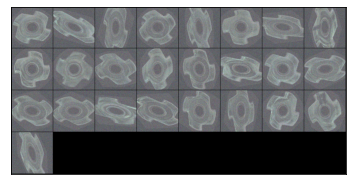

In [22]:
for x, labels in train_dl:
  img_grid = make_grid(x, normalize=True)
show(img_grid)

In [23]:
for x, y in train_dl:                                                   #WHY?
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1])


In [24]:
model = torch.nn.Sequential(timm.create_model('resnet18',pretrained=True,num_classes = config['num_classes']))
model.to(device)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [25]:
model(x.to(device)).shape

torch.Size([32, 2])

In [26]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #TODO
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [27]:
def calculate_metrics(pred, target):
    pred = np.argmax(pred, axis=1)
#     target = np.argmax(target, axis=1)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro')
           }

In [28]:
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,                                           
                    data_loader, optimizer: torch.optim.Optimizer,
                    device: torch.device, mb):
    model.train()
    losses = []

    for samples, targets in progress_bar(data_loader, parent = mb):
        batch_size = targets.size(0)
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)  
        outputs = model(samples)                          
        loss = criterion(outputs, targets)
        loss_value = loss.item()
        losses.append(loss_value)
        optimizer.zero_grad()      
        loss.backward()
        optimizer.step()
    
    return np.mean(losses)

def evaluate(model, criterion, data_loader, device):                                                      
    model.eval()
    losses = []
    list_outputs = []
    list_targets = []
    with torch.no_grad():
        for samples, targets in progress_bar(data_loader):
            batch_size = targets.size(0)

            samples = samples.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)        
            
            outputs = model(samples)
            loss = criterion(outputs, targets)
            loss_value = loss.item()
            losses.append(loss_value)
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()
            list_outputs += list(outputs)
            list_targets += list(targets)
        metric = calculate_metrics(np.array(list_outputs), np.array(list_targets))
    return np.mean(losses), metric

In [29]:
def inference(model, data_loader, device):                                               #WHY?       giống evaluate
    model.eval()
    list_outputs = []
    list_targets = []
    list_outputs_1 = []
    list_array_max_val = []
    with torch.no_grad():
        for x,targets in progress_bar(data_loader):
            batch_size = targets.size(0)

            x1=x.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True) 
            targets = targets.type(torch.LongTensor)
            
            model.to(device)
            outputs = model(x1)
            outputs_1 = torch.nn.functional.softmax(outputs).tolist()
            targets = targets.cpu().numpy()
            array_max_val = np.amax(torch.nn.functional.softmax(outputs).cpu().numpy(), axis=1)
            outputs = np.argmax(torch.nn.functional.softmax(outputs).cpu().numpy(),axis=1)


            list_outputs_1 += list(outputs_1)
            list_outputs += list(outputs)
            list_targets += list(targets)
            list_array_max_val +=list(array_max_val)
    return list_outputs_1, list_outputs, list_targets, list_array_max_val

In [30]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, 
                            lr = config['lr'], 
                            momentum=config['momentum'], 
                            weight_decay = config['weight_decay'])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size= config['lr_step_size'],
                                               gamma=config['lr_gamma'])

# criterion = torch.nn.CrossEntropyLoss()
criterion=FocalLoss()

In [ ]:
mb = master_bar(range(1, config['epochs']+1))

for epoch in mb:
    train_loss = train_one_epoch(model, criterion, train_dl, optimizer, device, mb)
    wandb.log({"train_loss": train_loss})
    lr_scheduler.step()
    
    print(f'Training epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    
    if (epoch)%2==0:
        valid_loss, valid_metric = evaluate(model, criterion, valid_dl, device)
        wandb.log({"valid_loss": valid_loss})
        print(f'\tValid Loss: {valid_loss:.3f}')
        print(f'\tMetric: {valid_metric}')

# wandb.config = {
#   "learning_rate": config['lr'],
#   "epochs": config['epochs'],
#   "batch_size": config['size'] 
# }


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 1
	Train Loss: 0.334


In [ ]:
df_list = pd.DataFrame([])
list_outputs_1, list_outputs, list_targets, list_array_max_val= inference(model, valid_dl, device)
df_list['list_targets']=list_targets
df_list['list_outputs']=list_outputs
df_list['max_probability']=list_array_max_val
df_list['list_outputs_1']=[np.array(item) for item in list_outputs_1]

In [ ]:
print(classification_report(list_outputs, list_targets))

In [ ]:
import seaborn as sns
C = confusion_matrix(list_targets, list_outputs)
cmn = C / C.astype('float').sum(axis=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

SEGMENTATION

In [ ]:
# define the test split
VALID_SPLIT = 0.1
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
PIN_MEMORY

In [ ]:
###UNET Training segmentation
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = config['size']
INPUT_IMAGE_HEIGHT = config['size']
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
# from locale import ABDAY_4
# mean = [0.485, 0.456, 0.406]                                               
# std = [0.229, 0.224, 0.225]

# train_transform = transforms.Compose(
#     [
#         A.Resize(config['size'], config['size']),
#         # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2,
#     ]
# )

# valid_transform = A.Compose(
#     [A.Resize(config['size'], config['size']), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
# )
# valid_transform = transforms.Compose([
#     transforms.Resize((config['size'],config['size'])),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)])

#U-Net: Training Image Segmentation Models in PyTorch
# class SegmentationDataset(Dataset):
#   def __init__(self, imagePaths, maskPaths, transforms):
#     # store the image and mask filepaths, and augmentation
#     # transforms
#     self.imagePaths = imagePaths
#     self.maskPaths = maskPaths
#     self.transforms = transforms
#   def __len__(self):
#     # return the number of total samples contained in the dataset
#     return len(self.imagePaths)
#   def __getitem__(self, idx):
#     # grab the image path from the current index
#     imagePath = self.imagePaths[idx]
#     # load the image from disk, swap its channels from BGR to RGB,
#     # and read the associated mask from disk in grayscale mode
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     img = Image.fromarray(image)

#     mask_array = cv2.imread(self.maskPaths[idx])
#     mask_array_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
#     mask = Image.fromarray(mask_array_bw)
#     # check to see if we are applying any transformations
#     if self.transforms is not None:
#       # apply the transformations to both image and its mask
#       image = self.transforms(image)
#       mask = self.transforms(mask)
#     # return a tuple of the image and its mask
#     return (image, mask)

In [ ]:
class MetalDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transform = None) :
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transform = transform
        
    def __len__(self) :
        return len(self.imagePaths)
    
    def __getitem__(self, index) :

        img_path = self.imagePaths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask_array = cv2.imread(self.maskPaths[index])
        mask_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
        ## structure transform
        if self.transform:
            transformed = self.transform(image = img)
            image = transformed["image"]
            # mask = transformed["mask"]

        # labels = torch.IntTensor(labels)
        # mask_bw_ = torch.FloatTensor(np.expand_dims(mask_bw_,axis=0))
        return img, mask_bw

In [ ]:
### Add by the residual connection
class Block(Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
		# store the convolution and RELU layers
    self.conv1 = Conv2d(inChannels, outChannels, 3)
    self.bn1 = BatchNorm2d(outChannels)
    self.relu = ReLU()
    self.conv2 = Conv2d(outChannels, outChannels, 3)
    self.bn2 = BatchNorm2d(outChannels)
  def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
    return self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))

In [ ]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [ ]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks 
    # ConvTranspose2d using for upsampling block
    # encFeatures : the list of intermediate outputs from the encoder
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks => to make sure the dimension of encFeature is equal to x
			# concatenate them with our current upsampled feature map x, along the channel dimension
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [ ]:
### Encoder start with 3 channels
### Encoder double the number of channels. Decoder reduce the channels by a factor of 2 at every step
### nbClasses: This defines the number of segmentation classes where we have to classify each pixel
### retainDim: This indicates whether we want to retain the original output dimension.
### outSize: This determines the spatial dimensions of the output segmentation map. We set this to the same dimension as our input image
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16),
              nbClasses=1, retainDim=True,outSize=(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize
  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
    encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
      # return the segmentation map
    return map

In [ ]:
# load the image and mask filepaths in a sorted manner
df_segmendata = pd.read_csv('./segmentation.csv')
df_segmendata.head()
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
Xseg_train, Xseg_val, yseg_train, yseg_val = train_test_split(df_segmendata['imgs'], df_segmendata['mask'],test_size=VALID_SPLIT, random_state=42)

In [ ]:
# U-Net: Training Image Segmentation Models in PyTorch
class SegmentationDataset(Dataset):
  def __init__(self, imagePaths, maskPaths, transforms,mask_transform):
    # store the image and mask filepaths, and augmentation
    # transforms
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms
    self.mask_transform=mask_transform
  def __len__(self):
    # return the number of total samples contained in the dataset
    return len(self.imagePaths)
  def __getitem__(self, idx):
    # # grab the image path from the current index
    # imagePath = self.imagePaths[idx]
    # # load the image from disk, swap its channels from BGR to RGB,
    # # and read the associated mask from disk in grayscale mode
    # image = cv2.imread(imagePath)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # img = Image.fromarray(image)

    # mask_array = cv2.imread(self.maskPaths[idx])
    # mask_array_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
    # mask = Image.fromarray(mask_array_bw)
    # grab the image path from the current index
    imagePath = self.imagePaths[idx]
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], 0)
    mask_array_bw = cv2.threshold(mask,128, 1, cv2.THRESH_BINARY)[1]
    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.mask_transform(mask)

    # return a tuple of the image and its mask
    return (image, mask_array_bw)

In [ ]:
train_trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['size'],config['size'])),
        # transforms.RandomResizedCrop(config['size']),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(200), 
        transforms.ToTensor(),
        GaussianNoise(0.1, 0.2),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
mask_trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['size'],config['size'])),
        # transforms.RandomResizedCrop(config['size']),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(200),   
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.5), std=(0.5)),
    ])

In [ ]:
trainseg_ds = SegmentationDataset(imagePaths=list(Xseg_train), maskPaths=list(yseg_train), transforms = train_trans,mask_transform=mask_trans)
validseg_ds = SegmentationDataset(imagePaths=list(Xseg_val), maskPaths=list(yseg_val), transforms = train_trans,mask_transform=mask_trans)
trainseg_dl = DataLoader(trainseg_ds, config['batch_size'], config['num_workers'])    
validseg_dl = DataLoader(validseg_ds, config['batch_size'], config['num_workers'])

In [ ]:
# aug = A.Compose([
#     # A.OneOf([
#     #     # A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
#     #     # A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
#     # ], p=1),    
#     A.VerticalFlip(p=0.5),              
#     A.RandomRotate90(p=0.5),
#     A.OneOf([
#         A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#         A.GridDistortion(p=0.5),
#         A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
#         ], p=0.8),
#     A.CLAHE(p=0.8),
#     A.RandomBrightnessContrast(p=0.8),    
#     A.RandomGamma(p=0.8)],
#     TensorV2())

In [ ]:
for x, labels in trainseg_dl:
  img_grid = make_grid(x, normalize=True)
show(img_grid)

In [ ]:
labels.max()

In [ ]:
labels.min()

In [ ]:
x.shape

In [ ]:
class FocalLoss_(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss_, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [ ]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = FocalLoss_()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainseg_dl)
testSteps = len(validseg_dl) 
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
len(trainseg_dl)

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config['epochs'])):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainseg_dl):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in validseg_dl:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config['epochs']))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

In [ ]:
pred.shape

In [ ]:
y.shape

In [ ]:
break

In [ ]:
def acc(input, target):
    """
    segmentation accuracy
    """
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def dice(input, targs):#->Rank0Tensor:
    """
    DICE score is the F1-score for the segmentation problems. 
    """
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.squeeze(1).view(n,-1)
    intersect = (input*targs).float().sum()
    union = (input+targs).float().sum()
    return 2. * intersect / union
    
def iou(input, targs):#->Rank0Tensor:
    """
    Intersection over Union
    """
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.squeeze(1).view(n,-1)
    intersect = (input*targs).float().sum()
    union = (input+targs).float().sum()
    return intersect / (union-intersect+1.0)

In [ ]:
iou(pred,y)